<a href="https://colab.research.google.com/github/Leanse1/Tracking-people-not-using-Zebra-crossing/blob/main/Tracking_People_not_using_Zebra_Crossing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/Pedestrians On Zebra Crossing Stock Video.mp4"

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

MODEL = "yolov8s.pt"
model = YOLO(MODEL)
model.fuse() # Fuse the Conv2d() and BatchNorm2d() layers of the model into a single layer

100%|██████████| 21.5M/21.5M [00:00<00:00, 153MB/s]


YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


In [ ]:
model.model.names[0]

'person'

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

In [ ]:
CLASS_NAMES_DICT[0]

'person'

In [ ]:
selected_classes = [0]

In [ ]:
!pip install supervision

In [ ]:
import supervision as sv

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/false-counter.mp4"

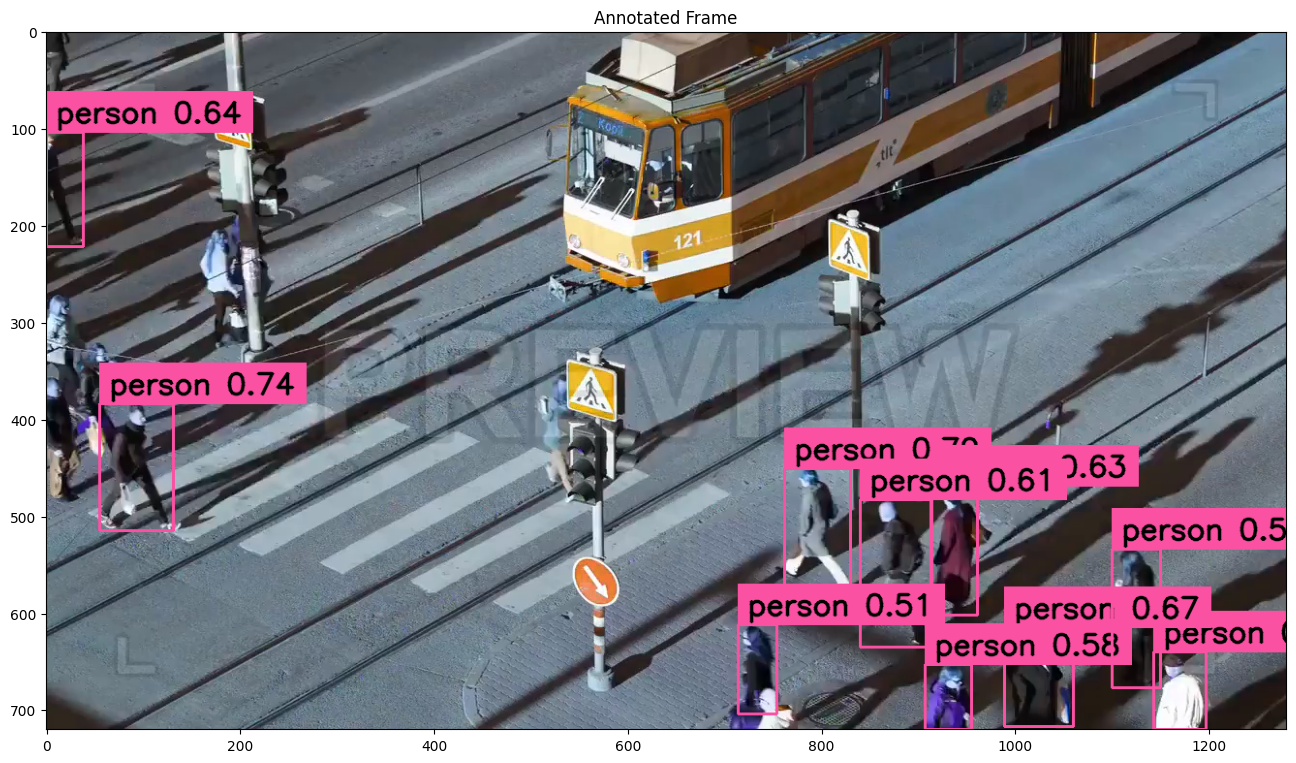

In [ ]:

import matplotlib.pyplot as plt

# video frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# initialize an iterator and fetch the first item from it,
iterator = iter(generator)
frame = next(iterator)
#instance of a model for inference
results = model(frame, verbose=False)[0]

# Convert to Detections using sv.Detections.from_ultralytics
box_annotator = sv.BoxAnnotator(thickness=2, text_thickness=2, text_scale=1)
detections = sv.Detections.from_ultralytics(results)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5)]


# format custom labels to only persons
labels = [
    f"{CLASS_NAMES_DICT[0]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]
# Annotate the frame using your BoxAnnotator instance
annotated_frame = box_annotator.annotate(scene = frame, detections = detections,labels = labels)

# Display the original and annotated frames using matplotlib
plt.figure(figsize=(16, 16))

plt.imshow(annotated_frame)
plt.title('Annotated Frame')

plt.show()

In [ ]:
colors = sv.ColorPalette.default()

In [38]:
import numpy as np
import supervision as sv
from supervision import PolygonZoneAnnotator
from IPython import display

byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

polygons = [np.array([
    [280, 379],
    [510, 257],
    [873, 349],
    [711, 469]
]),np.array([
    [51, 494],
    [1, 515],
    [1, 720],
    [377, 720],
    [486, 604]
])
]

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(1),
        thickness=1,
        text_thickness=4,
        text_scale=1
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(1),
        thickness=2,
        text_thickness=2,
        text_scale=1
        )
    for index
    in range(len(polygons))
]
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

In [ ]:
detections

Detections(xyxy=array([[     55.506,      384.13,      131.91,      515.99],
       [     762.69,      451.89,      830.93,      575.12],
       [     1143.7,       640.9,      1197.8,         720],
       [     989.82,      615.92,      1060.3,      717.21],
       [  0.0095711,      104.74,      38.336,      222.75],
       [     914.65,      469.93,      961.42,       602.1],
       [     840.78,       483.5,       913.8,      635.05],
       [     907.74,      653.39,      955.12,         720],
       [     1100.3,      534.24,      1150.2,      677.34],
       [     714.45,      612.74,      754.73,      704.08]], dtype=float32), mask=None, confidence=array([    0.73743,       0.699,     0.67947,     0.66605,     0.64396,      0.6274,     0.60711,     0.58029,     0.51892,     0.51333], dtype=float32), class_id=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), tracker_id=None)

In [42]:
def process_frame(frame: np.ndarray, i) -> np.ndarray:
    # Perform object detection using the model
    results = model(frame, imgsz=1280)[0]

    # Filter detections based on confidence and selected classes
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[(detections.class_id == 0)]

    # Process each zone with its annotators
    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        # Trigger the zone and filter detections accordingly
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]


        # Annotate the frame with bounding boxes and labels
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)

        # Annotate the frame with zone-specific information
        frame = zone_annotator.annotate(scene=frame)
    return frame  # Note: The annotated_frame is not being used after this line, consider returning it if needed





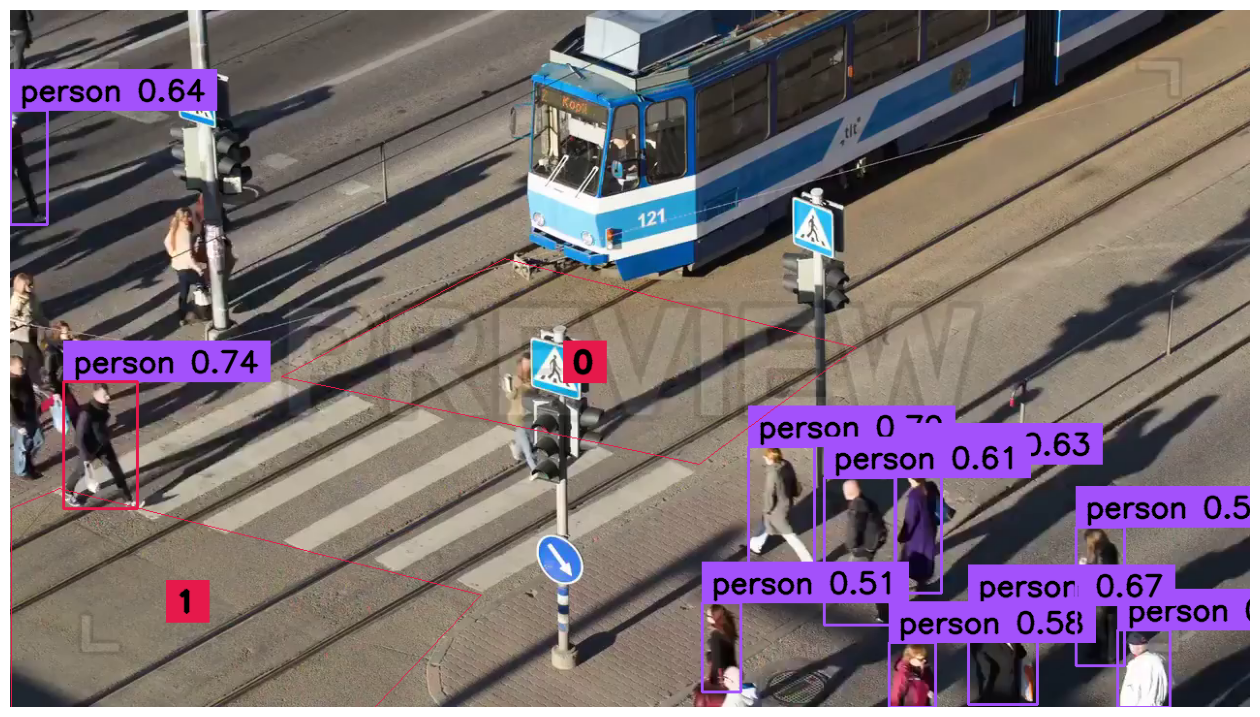

In [39]:
for zone, zone_annotator, box_annotator, labels_zone in zip(zones, zone_annotators, box_annotators, labels):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
    frame = zone_annotator.annotate(scene=frame)

# After the loop, plot the final annotated frame
sv.plot_image(frame, (16, 16))



In [43]:
sv.process_video(source_path=SOURCE_VIDEO_PATH, target_path=TARGET_VIDEO_PATH, callback=process_frame)